In [1]:
import numpy as np
from matplotlib import pyplot as plt, animation

from sklearn.datasets import make_blobs

from skactiveml.utils import MISSING_LABEL, labeled_indices, unlabeled_indices
from skactiveml.visualization import plot_utilities, plot_decision_boundary
from skactiveml.visualization._misc import mesh
  
from skactiveml.classifier import ParzenWindowClassifier

from skactiveml.base import SingleAnnotatorPoolQueryStrategy
from sklearn.metrics import pairwise_distances

In [2]:
class CoreSet(SingleAnnotatorPoolQueryStrategy):
    """ Core Set Selection

    This class implement various core-set based query strategies, i.e., the
    standard greedy algorithm for k-center problem [1], the robust k-center
    algorithm [1].

    Parameters
    ----------
    method: {'greedy', 'robust'}, default='greedy'
        The method to solve the k-center problem, k-center-greedy and robust
        k-center are possible
    missing_label: scalar or string or np.nan or None, default=np.nan
        Value to represent a missing label
    random_state: int or np.random.RandomState
        The random state to use

    References
    ----------
    [1] O. Sener und S. Savarese, „ACTIVE LEARNING FOR CONVOLUTIONAL NEURAL 
    NETWORKS: A CORE-SET APPROACH“, 2018.
    """

    def __init__(
        self, method='greedy', missing_label=MISSING_LABEL, random_state=None
    ):
        super().__init__(
            missing_label=missing_label, random_state=random_state
        )

        self.method = method
    
    def query(
            self, 
            X, 
            y,
            candidates=None,
            batch_size=1,
            return_utilities=False,
        ):
         
         """ Query the next instances to be labeled

         Parameters
         ----------
         X: array-like of shape (n_samples, n_features)
            Training data set, usually complete, i.e. including the labeled and
            unlabeled samples
         y: array-like of shape (n_samples, )
            Labels of the training data set (possibly including unlabeles ones
            indicated by self.missing_label)
         candidates: None or array-like of shape (n_candidates), dtype = int or
            array-like of shape (n_candidates, n_features),
            optional (default=None)
            If candidates is None, the unlabeled samples from (X,y) are considered
            as candidates
         batch_size: int, optional(default=1)
            The number of samples to be selectes in one AL cycle.
         return_utilities: bool, optional(default=False)
            If True, also return the utilites based on the query strategy

         Returns
         ----------
         query_indices: numpy.ndarry of shape (batch_size, )
            The query_indices indicate for which candidate sample a label is
            to queried, e.g., `query_indices[0]` indicates the first selected
            sample.
         utilities: numpy.ndarray of shape (n_samples, )
            The distance between each data point and its nearest center after
            each selected sample of the batch
         """
        
         X, y, candidates, batch_size, return_utilities = self._validate_data(
            X, y, candidates, batch_size, return_utilities, reset=True
        )
         
         X_cand, mapping = self._transform_candidates(candidates, X, y)
         selected_samples = labeled_indices(y, missing_label=self.missing_label)
         
         if self.method == 'greedy':
             query_indices, utilities = self.k_greedy_center(X, selected_samples, batch_size)

         if return_utilities:
             return query_indices, utilities
         else:
             return query_indices
    
    def k_greedy_center(self, X, selected_samples, batch_size):
        """
         An active learning method that greedily forms a batch to minimize 
         the maximum distance to a cluster center among all unlabeled
         datapoints.

         Parameters:
         ----------
         X: array-like of shape (n_samples, n_features)
            Training data set, usually complete, i.e. including the labeled and
            unlabeled samples
         selected_samples: np.ndarray of shape (n_seleted_samples, )
            index of datapoints already selectes
         batch_size: int, optional(default=1)
            The number of samples to be selectes in one AL cycle.
        
         Return:
         ----------
         new_samples: numpy.ndarry of shape (batch_size, )
            The query_indices indicate for which candidate sample a label is
            to queried from the candidates
         utilities: numpy.ndarray of shape (n_samples, )
            The distance between each data point and its nearest center after
            each selected sample of the batch
        """

        if len(selected_samples) > 0:
            min_distances = self.update_distances(X, selected_samples)

        query_indices = np.array([], dtype=int)

        for _ in range(batch_size):
            if len(selected_samples) == 0:
                idx = self.random_state_.choice(np.arange(X.shape[0]))
            else:
                idx = np.argmax(min_distances)
            assert idx not in selected_samples

            query_indices = np.append(query_indices, [idx])
            selected_samples = np.append(selected_samples, [idx])
            min_distances = self.update_distances(X, selected_samples)
        
        min_distances = np.where(min_distances == 0, np.nan, min_distances)
                
        return query_indices, min_distances
    
    def update_distances(self, X, cluster_centers):
        """ 
         Update min distances by given cluster centers.

         Parameters:
         ----------
         X: array-like of shape (n_samples, n_features)
            Training data set, usually complete, i.e. including the labeled and
            unlabeled samples
         cluster_centers: indices of cluster centers

         Return:
         ---------
         dist: numpy.ndarray of shape (n_samples, )
            The distance between each data point and its nearest center after
            each selected sample of the batch
        """
        if len(cluster_centers) == 0:
            return np.full(shape=len(X), fill_value=np.nan)

        cluster_center_feature = X[cluster_centers]
        dist_matrix = pairwise_distances(X, cluster_center_feature)
        dist = np.min(dist_matrix, axis=1).reshape(1,-1)

        return dist

In [3]:
# Begin of Test
random_state = np.random.RandomState(0)

In [4]:
# Build a dataset.
X, y_true = make_blobs(n_samples=100, n_features=2,
                       centers=[[0, 1], [-3, .5], [-1, -1], [2, 1], [1, -.5]],
                       cluster_std=.7, random_state=random_state)
y_true = y_true % 2
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

Text(0.5, 1.0, 'Data set')

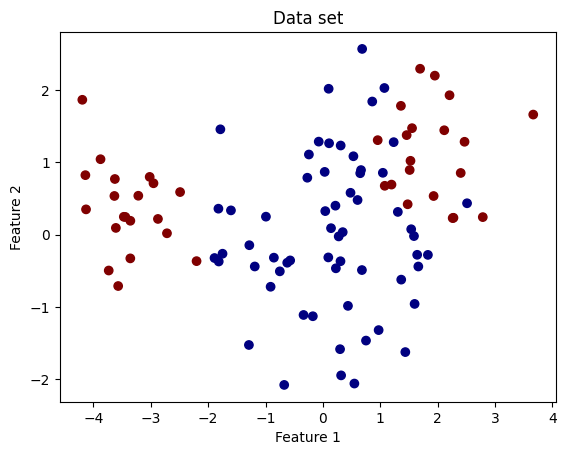

In [5]:
bound = [[min(X[:,0]), min(X[:,1])], [max(X[:,0]), max(X[:,1])]] # [[x0_min, x1_min], [x0_max, x1_max]] 2*2 __class__: list
# plot the dataset
plt.scatter(X[:, 0], X[:, 1], c=y_true, cmap='jet')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Data set')

In [6]:
# Initialise the classifier.
clf = ParzenWindowClassifier(classes=[0, 1], random_state=random_state)
# Initialise the query strategy.
qs = CoreSet()

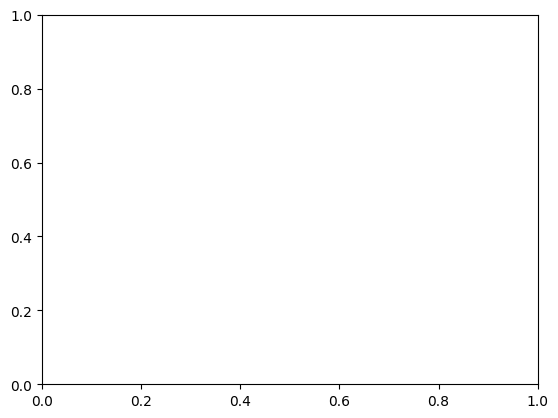

In [7]:
# Preparation for plotting.
fig, ax = plt.subplots()
feature_bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
artists = []

In [9]:

# The active learning cycle:
n_cycles = 2
for c in range(n_cycles):
    # Fit the classifier.
    clf.fit(X, y)

    # Get labeled instances.
    X_labeled = X[labeled_indices(y)]

    # Query the next instance/s.
    query_idx, utilities = qs.query(X=X, y=y, return_utilities=True)
    print(utilities.shape)

    # Plot the labeled data.
    coll_old = list(ax.collections)
    title = ax.text(
        0.5, 1.05, f"Decision boundary after acquring {c} labels",
        size=plt.rcParams["axes.titlesize"], ha="center",
        transform=ax.transAxes
    )
    ax = plot_utilities(qs, X=X, y=y,
                        candidates=None, res=10,
                        feature_bound=feature_bound, ax=ax)
    ax.scatter(X[:, 0], X[:, 1], c=y_true, cmap="coolwarm", marker=".",
               zorder=2)
    ax.scatter(X_labeled[:, 0], X_labeled[:, 1], c="grey", alpha=.8,
               marker=".", s=300)
    ax = plot_decision_boundary(clf, feature_bound, ax=ax)

    coll_new = list(ax.collections)
    coll_new.append(title)
    artists.append([x for x in coll_new if (x not in coll_old)])

    # Label the queried instances.
    y[query_idx] = y_true[query_idx]

ani = animation.ArtistAnimation(fig, artists, interval=1000, blit=True)

(1, 100)
(1, 100)
